### model 학습?
- 단어사전 만들고
- feature랑 label 들고 와서 학습?
- 형태소 분석기는 okt를 쓸거임

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re
import pickle
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, DataLoader

import work_rnn_func as rnn

In [2]:
DATA_PATH = './korean_food.csv'
KO_STOPWORD = rnn.load_ko_stopwrod()

In [3]:
data_df = pd.read_csv(DATA_PATH, encoding='utf-8')
data_df

,id,subtitle,title,img_url,level,level_code,link,time,element,feature
0,1,LG 광파오븐 레시피,고추전,https://static.wtable.co.kr/image/production/s...,중급,1,https://wtable.co.kr/recipes/SyRXB1s98K1pUgygq...,30분,"['아삭이고추', '다진 돼지고기', '두부', '양파', '부침가루', '계란 흰...",광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...
1,2,LG 광파오븐 레시피,황태갈비,https://static.wtable.co.kr/image/production/s...,초급,0,https://wtable.co.kr/recipes/UasAyakY1sXVT9QzE...,25분,"['황태', '밀가루', '전분', '식용유', '간장', '올리고당', '갈색 설...",광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...
2,3,귀한 성게가 듬뿍,성게미역국,https://static.wtable.co.kr/image/production/s...,초급,0,https://wtable.co.kr/recipes/aqnyvZDijf8Ui8o4G...,30분,"['성게', '건 미역', '다시마 육수', '국간장', '참기름', '멸치액젓',...",귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...
3,4,바다 향 가득,멍게비빔밥,https://static.wtable.co.kr/image/production/s...,초급,0,https://wtable.co.kr/recipes/ZpPmCXsRTNydMf2pk...,10분,"['멍게', '부추', '청양고추', '밥', '다진 마늘', '소금', '참기름'...",바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...
4,5,비 오는 날엔,곤드레전,https://static.wtable.co.kr/image/production/s...,초급,0,https://wtable.co.kr/recipes/j7EELtk9r1nfhGShB...,20분,"['생 곤드레', '식용유', '소금', '부침가루', '물', '간장', '맛술'...",비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...
...,...,...,...,...,...,...,...,...,...,...
417,418,안심살로 만들어 더 부드러운,돼지고기장조림,https://static.wtable.co.kr/image/production/s...,중급,1,https://wtable.co.kr/recipes/y4wwLB1sGGjdCLosW...,50분,"['돼지고기', '달걀', '물', '대파', '양파', '마늘', '생강', '통...",안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...
418,419,동그란 보름달을 닮은,약식,https://static.wtable.co.kr/image/production/s...,중급,1,https://wtable.co.kr/recipes/71sGWbjPuEFnkAPrQ...,50분,"['찹쌀', '대추', '밤', '잣', '물', '참기름', '대추 씨 끓인 물'...",동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...
419,420,봄의 영양이 듬뿍 담긴,주꾸미볶음,https://static.wtable.co.kr/image/production/s...,중급,1,https://wtable.co.kr/recipes/1NKrRoLSiCRZ7Rm1b...,35분,"['주꾸미', '양파', '당근', '대파', '청양고추', '홍고추', '소면',...",봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...
420,421,보라색 채소의 최강자!,가지볶음,https://static.wtable.co.kr/image/production/s...,초급,0,https://wtable.co.kr/recipes/fZuC5DSY4QtNTr7pr...,20분,"['가지', '양파', '청양고추', '홍고추', '대파', '참기름', '통깨',...",보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...


In [4]:
use_df = data_df[['feature', 'level_code']]
use_df

,feature,level_code
0,광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...,1
1,광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...,0
2,귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...,0
3,바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...,0
4,비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...,0
...,...,...
417,안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...,1
418,동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...,1
419,봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...,1
420,보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...,0


In [5]:
use_df.columns = ['text', 'label']
use_df

,text,label
0,광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...,1
1,광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...,0
2,귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...,0
3,바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...,0
4,비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...,0
...,...,...
417,안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...,1
418,동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...,1
419,봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...,1
420,보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...,0


In [6]:
del_stop = []
for text in rnn.delete_stopwords(use_df, KO_STOPWORD):
    del_stop.append(text)
del_stop

[[['오븐',
   '레시피',
   '고추전',
   '삭이',
   '고추',
   '다진',
   '돼지고기',
   '두부',
   '양파',
   '부침',
   '가루',
   '계란',
   '흰자',
   '홍',
   '고추',
   '굴소스',
   '청주',
   '다진',
   '마늘',
   '생강',
   '가루',
   '참기름',
   '소금',
   '후춧가루',
   '달걀',
   '부침',
   '가루',
   '진',
   '간장',
   '물',
   '설탕',
   '식초',
   '다진',
   '양파',
   '청',
   '고추',
   '삭',
   '고',
   '추',
   '황',
   '태',
   '성',
   '게',
   '멍',
   '게',
   '생',
   '곤',
   '드',
   '레',
   '불',
   '린',
   '쌀',
   '불',
   '린',
   '미',
   '역',
   '부',
   '지',
   '깽',
   '욱',
   '근',
   '대',
   '래',
   '떡',
   '고',
   '필',
   '렛',
   '도',
   '토',
   '리',
   '루',
   '목',
   '살',
   '배',
   '표',
   '고',
   '지',
   '신',
   '김',
   '치',
   '열',
   '무',
   '른',
   '쇠',
   '고',
   '기',
   '양',
   '지',
   '당',
   '근',
   '신',
   '김',
   '치',
   '표',
   '고',
   '버',
   '섯',
   '냉',
   '얼',
   '갈',
   '배',
   '추',
   '청',
   '양',
   '고',
   '추',
   '불',
   '린',
   '쌀',
   '비',
   '타',
   '민',
   '불',
   '린',
   '쌀',
   '불',
   '린',
   '쌀',
   '불',
   '린',


In [7]:
use_df['del_stop'] = del_stop[0]
use_df

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22700\941599162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df['del_stop'] = del_stop[0]


,text,label,del_stop
0,광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...,1,"[오븐, 레시피, 고추전, 삭이, 고추, 다진, 돼지고기, 두부, 양파, 부침, 가..."
1,광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...,0,"[오븐, 레시피, 황태, 갈비, 황태, 밀가루, 전분, 식용유, 간장, 올리고당, ..."
2,귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...,0,"[귀한, 성게, 듬뿍, 성게, 미역국, 성게, 건, 미역, 다시마, 육수, 국, 간..."
3,바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...,0,"[바다, 향, 가득, 멍게, 비빔밥, 멍게, 부추, 청양고추, 밥, 다진, 마늘, ..."
4,비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...,0,"[비, 오는, 날, 엔, 곤드레, 전, 생, 곤드레, 식용유, 소금, 부침, 가루,..."
...,...,...,...
417,안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...,1,"[안심, 살로, 만들어, 더, 부드러운, 돼지고기, 장조림, 돼지고기, 달걀, 물,..."
418,동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...,1,"[동그란, 보름달, 닮은, 약식, 찹쌀, 대추, 밤, 잣, 물, 참기름, 대추, 씨..."
419,봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...,1,"[봄, 영양, 듬뿍, 담긴, 주꾸미, 볶음, 주꾸미, 양파, 당근, 대파, 청양고추..."
420,보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...,0,"[보라색, 채소, 최강, 가지, 볶음, 가지, 양파, 청양고추, 홍, 고추, 대파,..."


In [8]:
token_freq = rnn.token_frequence(use_df)
token_freq

{'오븐': 7,
 '레시피': 17,
 '고추전': 1,
 '삭이': 1,
 '고추': 185,
 '다진': 392,
 '돼지고기': 33,
 '두부': 61,
 '양파': 197,
 '부침': 36,
 '가루': 127,
 '계란': 2,
 '흰자': 4,
 '홍': 262,
 '굴소스': 25,
 '청주': 28,
 '마늘': 351,
 '생강': 80,
 '참기름': 264,
 '소금': 261,
 '후춧가루': 189,
 '달걀': 96,
 '진': 459,
 '간장': 358,
 '물': 495,
 '설탕': 229,
 '식초': 88,
 '청': 271,
 '삭': 5,
 '고': 791,
 '추': 542,
 '황': 14,
 '태': 12,
 '성': 3,
 '게': 16,
 '멍': 3,
 '생': 107,
 '곤': 2,
 '드': 8,
 '레': 13,
 '불': 27,
 '린': 30,
 '쌀': 87,
 '미': 66,
 '역': 12,
 '부': 123,
 '지': 84,
 '깽': 3,
 '욱': 2,
 '근': 75,
 '대': 188,
 '래': 14,
 '떡': 19,
 '필': 1,
 '렛': 1,
 '도': 18,
 '토': 3,
 '리': 185,
 '루': 511,
 '목': 5,
 '살': 46,
 '배': 79,
 '표': 45,
 '신': 14,
 '김': 123,
 '치': 186,
 '열': 4,
 '무': 140,
 '른': 9,
 '쇠': 30,
 '기': 391,
 '양': 349,
 '당': 175,
 '버': 100,
 '섯': 93,
 '냉': 13,
 '얼': 11,
 '갈': 19,
 '비': 21,
 '타': 14,
 '민': 3,
 '두': 72,
 '돼': 30,
 '굴': 56,
 '소': 352,
 '북': 2,
 '채': 32,
 '패': 3,
 '겹': 12,
 '닭': 30,
 '합': 3,
 '감': 33,
 '새': 76,
 '우': 53,
 '프': 16,
 '랑': 2,
 '

In [9]:
sorted_data_list = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)
sorted_data_list

[('고', 791),
 ('추', 542),
 ('파', 542),
 ('다', 523),
 ('루', 511),
 ('물', 495),
 ('마', 489),
 ('장', 489),
 ('진', 459),
 ('다진', 392),
 ('기', 391),
 ('춧', 361),
 ('간장', 358),
 ('소', 352),
 ('간', 352),
 ('마늘', 351),
 ('양', 349),
 ('늘', 346),
 ('름', 311),
 ('금', 297),
 ('깨', 284),
 ('청', 271),
 ('참기름', 264),
 ('홍', 262),
 ('소금', 261),
 ('통', 260),
 ('후', 251),
 ('맛', 248),
 ('탕', 239),
 ('설', 234),
 ('설탕', 229),
 ('통깨', 224),
 ('식', 209),
 ('양파', 197),
 ('맛술', 197),
 ('술', 197),
 ('후춧가루', 189),
 ('대', 188),
 ('치', 186),
 ('고추', 185),
 ('리', 185),
 ('당', 175),
 ('국', 175),
 ('대파', 171),
 ('고춧가루', 166),
 ('용', 163),
 ('밥', 151),
 ('유', 150),
 ('시', 147),
 ('무', 140),
 ('수', 133),
 ('가루', 127),
 ('부', 123),
 ('김', 123),
 ('청양고추', 123),
 ('다시마', 118),
 ('식용유', 117),
 ('생', 107),
 ('육수', 102),
 ('버', 100),
 ('초', 98),
 ('올', 97),
 ('달걀', 96),
 ('멸', 96),
 ('섯', 93),
 ('식초', 88),
 ('달', 88),
 ('올리고당', 88),
 ('멸치', 88),
 ('쌀', 87),
 ('강', 85),
 ('지', 84),
 ('은', 84),
 ('고추장', 84),
 ('걀', 82),
 ('생강

In [10]:
korean_vocab = rnn.create_vocab(token_freq)
len(korean_vocab)

1427

In [11]:
# 객체 저장
with open('koran_vocab.pkl', 'wb') as f:
    pickle.dump(korean_vocab, f)


In [12]:
enco_list = []
for text in rnn.encoding(use_df, korean_vocab):
    enco_list.append(text)
enco_list

[[[321,
   182,
   841,
   842,
   41,
   11,
   126,
   86,
   35,
   119,
   53,
   617,
   434,
   25,
   41,
   147,
   142,
   11,
   17,
   77,
   53,
   24,
   26,
   38,
   64,
   119,
   53,
   10,
   14,
   7,
   32,
   67,
   11,
   35,
   23,
   41,
   390,
   2,
   3,
   200,
   229,
   513,
   191,
   514,
   191,
   59,
   618,
   290,
   209,
   143,
   136,
   71,
   143,
   136,
   83,
   230,
   54,
   73,
   515,
   619,
   80,
   39,
   201,
   169,
   2,
   843,
   844,
   177,
   516,
   42,
   6,
   391,
   101,
   78,
   104,
   2,
   73,
   202,
   55,
   40,
   435,
   51,
   270,
   137,
   2,
   12,
   18,
   73,
   43,
   80,
   202,
   55,
   40,
   104,
   2,
   61,
   66,
   210,
   242,
   170,
   78,
   3,
   23,
   18,
   2,
   3,
   143,
   136,
   71,
   161,
   203,
   517,
   143,
   136,
   71,
   143,
   136,
   71,
   143,
   136,
   71,
   143,
   136,
   71,
   143,
   136,
   71,
   81,
   54,
   143,
   136,
   71,
   138,
   73,
   2,
   

In [13]:
use_df['encoding'] = enco_list[0]
use_df

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22700\3707408143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df['encoding'] = enco_list[0]


,text,label,del_stop,encoding
0,광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...,1,"[오븐, 레시피, 고추전, 삭이, 고추, 다진, 돼지고기, 두부, 양파, 부침, 가...","[321, 182, 841, 842, 41, 11, 126, 86, 35, 119,..."
1,광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...,0,"[오븐, 레시피, 황태, 갈비, 황태, 밀가루, 전분, 식용유, 간장, 올리고당, ...","[321, 182, 217, 299, 217, 146, 163, 58, 14, 69..."
2,귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...,0,"[귀한, 성게, 듬뿍, 성게, 미역국, 성게, 건, 미역, 다시마, 육수, 국, 간...","[636, 530, 400, 530, 333, 530, 97, 178, 57, 60..."
3,바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...,0,"[바다, 향, 가득, 멍게, 비빔밥, 멍게, 부추, 청양고추, 밥, 다진, 마늘, ...","[303, 144, 220, 401, 274, 401, 114, 56, 48, 11..."
4,비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...,0,"[비, 오는, 날, 엔, 곤드레, 전, 생, 곤드레, 식용유, 소금, 부침, 가루,...","[161, 874, 528, 630, 457, 112, 59, 457, 58, 26..."
...,...,...,...,...
417,안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...,1,"[안심, 살로, 만들어, 더, 부드러운, 돼지고기, 장조림, 돼지고기, 달걀, 물,...","[372, 659, 660, 211, 367, 126, 613, 126, 64, 7..."
418,동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...,1,"[동그란, 보름달, 닮은, 약식, 찹쌀, 대추, 밤, 잣, 물, 참기름, 대추, 씨...","[1422, 1423, 1424, 1425, 160, 368, 453, 275, 7..."
419,봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...,1,"[봄, 영양, 듬뿍, 담긴, 주꾸미, 볶음, 주꾸미, 양파, 당근, 대파, 청양고추...","[152, 180, 400, 829, 512, 135, 512, 35, 82, 45..."
420,보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...,0,"[보라색, 채소, 최강, 가지, 볶음, 가지, 양파, 청양고추, 홍, 고추, 대파,...","[840, 402, 1426, 174, 135, 174, 35, 56, 25, 41..."


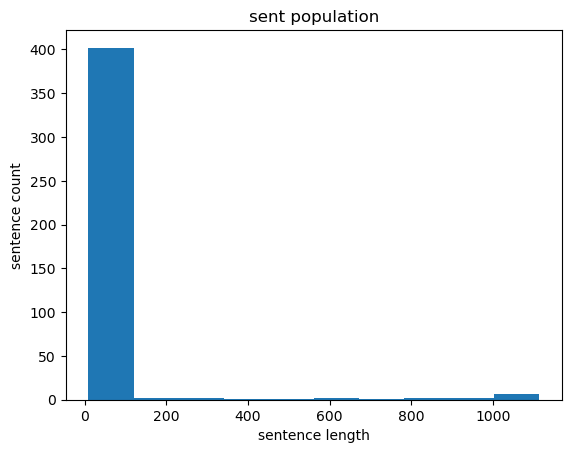

In [14]:
rnn.show_sent_pop(use_df)

In [15]:
def show_sent_pop(data_df, bin_=10):
    """
    show histogram sent population

    Args:
        data_df (DataFrame): encoding text data
    """
    encoding_data = data_df['encoding'].to_list()
    
    data_len_list = [len(sent) for sent in encoding_data]
    
    plt.hist(data_len_list, bins=bin_)
    plt.title('sent population')
    plt.xlabel('sentence length')
    plt.xlim((50, 150))
    plt.ylabel('sentence count')
    plt.show()

In [16]:
encoding_data = use_df['encoding'].to_list()
    
data_len_list = [len(sent) for sent in encoding_data]
data_len_list

[1114,
 1097,
 1061,
 1108,
 1105,
 1084,
 1081,
 986,
 917,
 890,
 805,
 710,
 661,
 594,
 545,
 430,
 309,
 235,
 217,
 162,
 108,
 106,
 92,
 88,
 70,
 62,
 38,
 21,
 20,
 23,
 22,
 21,
 17,
 15,
 14,
 23,
 30,
 26,
 20,
 26,
 21,
 27,
 21,
 17,
 20,
 20,
 26,
 21,
 21,
 17,
 17,
 15,
 18,
 18,
 25,
 15,
 16,
 10,
 15,
 20,
 30,
 27,
 16,
 13,
 21,
 23,
 20,
 15,
 24,
 31,
 14,
 18,
 22,
 21,
 29,
 16,
 26,
 24,
 26,
 24,
 29,
 13,
 23,
 28,
 18,
 18,
 27,
 23,
 25,
 18,
 15,
 23,
 24,
 28,
 30,
 20,
 35,
 34,
 37,
 25,
 26,
 32,
 26,
 28,
 21,
 21,
 22,
 23,
 24,
 45,
 35,
 24,
 18,
 18,
 28,
 21,
 20,
 32,
 16,
 18,
 21,
 20,
 15,
 29,
 21,
 25,
 33,
 18,
 21,
 24,
 21,
 26,
 24,
 14,
 23,
 16,
 26,
 26,
 23,
 48,
 38,
 13,
 32,
 24,
 23,
 48,
 22,
 27,
 37,
 27,
 25,
 19,
 29,
 19,
 33,
 21,
 23,
 19,
 23,
 25,
 30,
 33,
 13,
 18,
 29,
 30,
 25,
 13,
 20,
 18,
 29,
 25,
 24,
 29,
 26,
 28,
 27,
 9,
 12,
 13,
 16,
 23,
 15,
 14,
 22,
 27,
 26,
 31,
 19,
 19,
 20,
 25,
 29,
 21,
 2

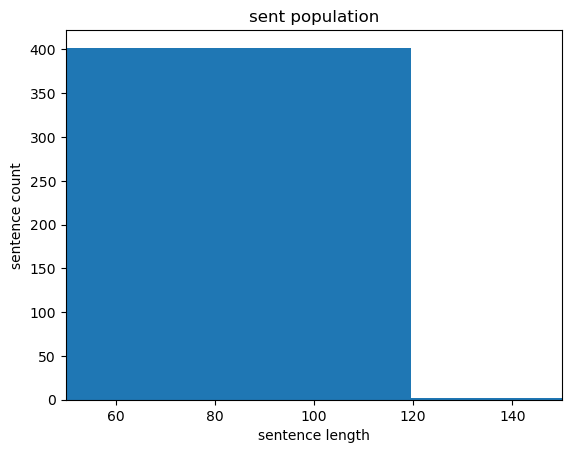

In [17]:
show_sent_pop(use_df, 10)

In [18]:
pad_list = rnn.padding(use_df, len_data=25)
use_df['padding_25'] = pad_list
use_df

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22700\4079369536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df['padding_25'] = pad_list


,text,label,del_stop,encoding,padding_25
0,광파오븐 레시피 고추전 아삭이고추 다진 돼지고기 두부 양파 부침가루 계란 흰자 ...,1,"[오븐, 레시피, 고추전, 삭이, 고추, 다진, 돼지고기, 두부, 양파, 부침, 가...","[321, 182, 841, 842, 41, 11, 126, 86, 35, 119,...","[321, 182, 841, 842, 41, 11, 126, 86, 35, 119,..."
1,광파오븐 레시피 황태갈비 황태 밀가루 전분 식용유 간장 올리고당 갈색 설탕 맛술...,0,"[오븐, 레시피, 황태, 갈비, 황태, 밀가루, 전분, 식용유, 간장, 올리고당, ...","[321, 182, 217, 299, 217, 146, 163, 58, 14, 69...","[321, 182, 217, 299, 217, 146, 163, 58, 14, 69..."
2,귀한 성게가 듬뿍 성게미역국 성게 건 미역 다시마 육수 국간장 참기름 멸치액젓 소...,0,"[귀한, 성게, 듬뿍, 성게, 미역국, 성게, 건, 미역, 다시마, 육수, 국, 간...","[636, 530, 400, 530, 333, 530, 97, 178, 57, 60...","[636, 530, 400, 530, 333, 530, 97, 178, 57, 60..."
3,바다 향 가득 멍게비빔밥 멍게 부추 청양고추 밥 다진 마늘 소금 참기름 깨소금 양...,0,"[바다, 향, 가득, 멍게, 비빔밥, 멍게, 부추, 청양고추, 밥, 다진, 마늘, ...","[303, 144, 220, 401, 274, 401, 114, 56, 48, 11...","[303, 144, 220, 401, 274, 401, 114, 56, 48, 11..."
4,비 오는 날엔 곤드레전 생 곤드레 식용유 소금 부침가루 물 간장 맛술 식초 잘게 ...,0,"[비, 오는, 날, 엔, 곤드레, 전, 생, 곤드레, 식용유, 소금, 부침, 가루,...","[161, 874, 528, 630, 457, 112, 59, 457, 58, 26...","[161, 874, 528, 630, 457, 112, 59, 457, 58, 26..."
...,...,...,...,...,...
417,안심살로 만들어 더 부드러운 돼지고기장조림 돼지고기 달걀 물 대파 양파 마늘 생강...,1,"[안심, 살로, 만들어, 더, 부드러운, 돼지고기, 장조림, 돼지고기, 달걀, 물,...","[372, 659, 660, 211, 367, 126, 613, 126, 64, 7...","[372, 659, 660, 211, 367, 126, 613, 126, 64, 7..."
418,동그란 보름달을 닮은 약식 찹쌀 대추 밤 잣 물 참기름 대추 씨 끓인 물 꿀 간장...,1,"[동그란, 보름달, 닮은, 약식, 찹쌀, 대추, 밤, 잣, 물, 참기름, 대추, 씨...","[1422, 1423, 1424, 1425, 160, 368, 453, 275, 7...","[1422, 1423, 1424, 1425, 160, 368, 453, 275, 7..."
419,봄의 영양이 듬뿍 담긴 주꾸미볶음 주꾸미 양파 당근 대파 청양고추 홍고추 소면 청...,1,"[봄, 영양, 듬뿍, 담긴, 주꾸미, 볶음, 주꾸미, 양파, 당근, 대파, 청양고추...","[152, 180, 400, 829, 512, 135, 512, 35, 82, 45...","[152, 180, 400, 829, 512, 135, 512, 35, 82, 45..."
420,보라색 채소의 최강자 가지볶음 가지 양파 청양고추 홍고추 대파 참기름 통깨 식용...,0,"[보라색, 채소, 최강, 가지, 볶음, 가지, 양파, 청양고추, 홍, 고추, 대파,...","[840, 402, 1426, 174, 135, 174, 35, 56, 25, 41...","[840, 402, 1426, 174, 135, 174, 35, 56, 25, 41..."


In [19]:
use_df.to_csv('./use_ko_df.csv', index=False, encoding='utf-8')

In [20]:
train_df_2 = use_df.sample(frac=0.9, random_state=rnn.RANDOM_STATE)
test_df = use_df.drop(train_df_2.index)

train_df = train_df_2.sample(frac=0.9, random_state=rnn.RANDOM_STATE)
val_df = train_df_2.drop(train_df.index)

print(f"train size: {len(train_df)}")
print(f"val size: {len(val_df)}")
print(f"test size: {len(test_df)}")

train size: 342
val size: 38
test size: 42


In [21]:
val_df = val_df.reset_index(drop=True)
val_df

,text,label,del_stop,encoding,padding_25
0,추억의 반찬 감자채볶음 감자 당근 양파 통깨 식용유 다진 마늘 소금,0,"[추억, 반찬, 감자, 채, 볶음, 감자, 당근, 양파, 통깨, 식용유, 다진, 마...","[704, 187, 108, 130, 135, 108, 82, 35, 33, 58,...","[704, 187, 108, 130, 135, 108, 82, 35, 33, 58,..."
1,야무지게 말았어요 묵은지 말이 묵은지 밥 참치 깻잎 양파 통깨 참기름 참기름 소...,0,"[야무지게, 말았어요, 묵은지, 말, 묵은지, 밥, 참치, 깻잎, 양파, 통깨, 참...","[1121, 1122, 181, 205, 181, 48, 134, 121, 35, ...","[1121, 1122, 181, 205, 181, 48, 134, 121, 35, ..."
2,이름만 들어도 푸짐한 산더미 물갈비 소갈비 쇠고기 양파 대파 팽이버섯 느타리버섯 ...,0,"[이름, 만, 들어도, 푸, 짐, 한, 산더미, 물, 갈비, 소갈비, 쇠고기, 양파...","[1025, 172, 1026, 727, 728, 85, 1027, 7, 299, ...","[1025, 172, 1026, 727, 728, 85, 1027, 7, 299, ..."
3,고소한 꽁치와 칼칼한 김치의 만남 꽁치김치찌개 꽁치통조림 배추김치 대파 청고추 ...,0,"[고소한, 꽁치, 칼칼한, 김치, 만남, 꽁치, 김치찌개, 꽁치, 통조림, 배추김치...","[305, 430, 309, 106, 411, 430, 697, 430, 388, ...","[305, 430, 309, 106, 411, 430, 697, 430, 388, ..."
4,젓갈 대신 간장으로 담그는 장김치 배추 무 오이 양파 표고버섯 마늘 홍고추 생강...,1,"[젓갈, 대신, 간장, 담그는, 장, 김치, 배추, 무, 오이, 양파, 표고버섯, ...","[715, 1012, 14, 1013, 9, 106, 186, 51, 93, 35,...","[715, 1012, 14, 1013, 9, 106, 186, 51, 93, 35,..."
5,은은한 향이 살아있는 표고버섯볶음 표고버섯 양파 당근 청양고추 다진마늘 카놀라유 ...,0,"[은은한, 향, 살아있는, 표고버섯, 볶음, 표고버섯, 양파, 당근, 청양고추, 다...","[466, 144, 511, 100, 135, 100, 35, 82, 56, 11,...","[466, 144, 511, 100, 135, 100, 35, 82, 56, 11,..."
6,칼칼하고 개운한 닭개장 닭 숙주 불린 고사리 느타리버섯 양파 대파 무 고추기름 소...,1,"[칼칼하고, 개운한, 닭개장, 닭, 숙주, 불린, 고사리, 느타리버섯, 양파, 대파...","[1273, 665, 1274, 139, 264, 153, 254, 253, 35,...","[1273, 665, 1274, 139, 264, 153, 254, 253, 35,..."
7,향긋한 더덕 생채 깐 더덕 송송 썬 쪽파 통깨 고추장 고운 고춧가루 물엿 간장 설...,0,"[향, 긋한, 더덕, 생채, 깐, 더덕, 송송, 썬, 쪽파, 통깨, 고추장, 고운,...","[144, 311, 502, 1140, 258, 502, 224, 116, 87, ...","[144, 311, 502, 1140, 258, 502, 224, 116, 87, ..."
8,언제나 인기 많은 레시피 무 짜글이 무 차돌박이 대파 홍고추 청양고추 다시마 멸치...,0,"[언제나, 인기, 많은, 레시피, 무, 짜, 글, 무, 차돌박이, 대파, 홍, 고추...","[1048, 734, 1049, 182, 51, 585, 475, 51, 223, ...","[1048, 734, 1049, 182, 51, 585, 475, 51, 223, ..."
9,멋스러운 명절요리 쇠고기산적꼬치 쇠고기 등심 파 새송이버섯 나무꼬치 잣가루 식용유...,0,"[멋, 스러운, 명절, 요리, 쇠고기, 산적, 꼬치, 쇠고기, 등심, 파, 새, 송...","[1345, 1346, 600, 278, 110, 1347, 286, 110, 74...","[1345, 1346, 600, 278, 110, 1347, 286, 110, 74..."


In [22]:
test_df = test_df.reset_index(drop=True)

In [23]:
train_df = train_df.reset_index(drop=True)

In [24]:
train_ids = train_df.padding_25
val_ids = val_df.padding_25
test_ids = test_df.padding_25

print(train_ids[0])
print(val_ids[0])
print(test_ids[0])

[1084, 574, 1085, 165, 29, 320, 106, 129, 165, 71, 320, 595, 106, 129, 117, 142, 594, 14, 0, 0, 0, 0, 0, 0, 0]
[704, 187, 108, 130, 135, 108, 82, 35, 33, 58, 11, 17, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[890, 336, 29, 461, 276, 461, 70, 57, 60, 45, 56, 99, 75, 11, 17, 23, 92, 5, 10, 8, 19, 232, 191, 116, 18]


In [25]:
train_ids = torch.tensor(train_ids)
val_ids = torch.tensor(val_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train_df.label.values, dtype=torch.float32)
val_labels = torch.tensor(val_df.label.values, dtype=torch.float32)
test_labels = torch.tensor(test_df.label.values, dtype=torch.float32)

train_datasets = TensorDataset(train_ids, train_labels)
val_datasets = TensorDataset(val_ids, val_labels)
test_datasets = TensorDataset(test_ids, test_labels)

In [26]:
n_vocab = len(korean_vocab)
hidden_dim = 64
embedding_dim = 128
n_layer = 3

lstm_model = rnn.BCRNNModels(n_vocab, hidden_dim, embedding_dim, n_layer)



In [27]:
print(lstm_model)
rnn.summary(lstm_model)

BCRNNModels(
  (embedding): Embedding(1427, 128, padding_idx=0)
  (model): LSTM(128, 64, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Layer (type:depth-idx)                   Param #
BCRNNModels                              --
├─Embedding: 1-1                         182,656
├─LSTM: 1-2                              297,984
├─Linear: 1-3                            129
├─Dropout: 1-4                           --
Total params: 480,769
Trainable params: 480,769
Non-trainable params: 0

In [28]:
EPOCHS = 100

loss_dict, acc_dict, f1_dict = rnn.training(lstm_model, test_datasets, val_datasets, EPOCHS)


saved first
[    2/  100] saved model
[    3/  100] saved model
[    5/  100]  [Train]         loss: 0.676092, score: 12.500000 %
[    5/  100]  [Validation]    loss: 0.665248, score: 16.666667 %

[    7/  100] saved model
[    9/  100] saved model
[   10/  100]  [Train]         loss: 0.561384, score: 79.220784 %
[   10/  100]  [Validation]    loss: 0.560596, score: 44.444445 %

[   15/  100]  [Train]         loss: 0.353238, score: 86.335403 %
[   15/  100]  [Validation]    loss: 0.524358, score: 56.000000 %

성능 및 손실의 개선이 없어서 학습을 중단합니다.

[   19/  100]  [Train]         loss: 0.182307, score: 91.133004 %
[   19/  100]  [Validation]    loss: 0.730237, score: 43.478259 %



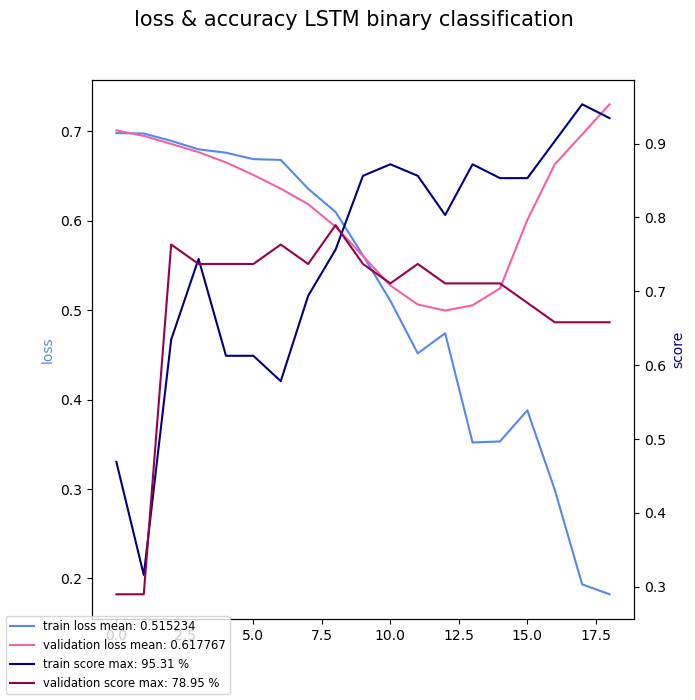

In [29]:
rnn.draw_two_plot(loss_dict, acc_dict, 'loss & accuracy')

In [30]:
lstm_model = torch.load('./model/bc_lstm_clf_model.pth', weights_only=False)

In [31]:
test_loss, test_acc, test_f1, test_mat = rnn.testing(lstm_model, test_datasets.tensors[0], test_datasets.tensors[1])

test loss: 0.5749938488006592
test accuracy: 80.952385 %
test f1 score: 71.428574 %


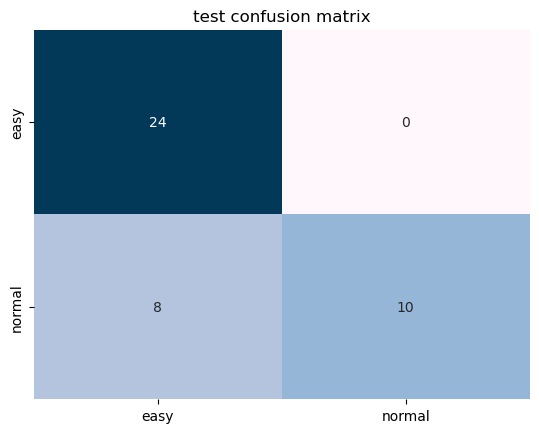

In [32]:
print(f"test loss: {test_loss}")
print(f"test accuracy: {test_acc*100:.6f} %")
print(f"test f1 score: {test_f1*100:.6f} %")

sns.heatmap(test_mat, annot=True, fmt=f'.0f', cbar=False, cmap='PuBu')
plt.title('test confusion matrix')
plt.xticks(np.arange(0, 2)+0.5, labels=[rnn.LABEL_TRANSLATE_EN[i] for i in range(2)])
plt.yticks(np.arange(0, 2)+0.5, labels=[rnn.LABEL_TRANSLATE_EN[i] for i in range(2)])
plt.show()